# Exploring Supermarket Sales Patterns in Ecuador





**Team 05-** Fangzhou Zheng, Pushpraj Singh, Sidhant Sidhant, Manan Goel, Lujia Yu, Yixi Yu


#Introduction and Motivation

This project aims to identify the key drivers of supermarket sales in Ecuador and provide actionable insights through an interactive Tableau dashboard. The dashboard integrates data from sales transactions, store information, promotions, oil prices, and holiday events to offer users an intuitive view of sales patterns across stores and product categories. The motivation for this project stems from the need to enhance decision-making for supermarket stakeholders by uncovering sales trends and external influences such as promotions, seasonality, and economic factors like oil prices. Understanding these dynamics is crucial for optimizing inventory management, refining promotional strategies, and catering to diverse consumer preferences. The business significance of this project lies in its potential to enable supermarkets to strategically align resources, mitigate risks from fluctuating market conditions, and enhance profitability by responding proactively to consumer demand and external trends. By leveraging a data-driven approach, this project empowers stakeholders to adapt to market changes, improve operational efficiency, and maximize profitability.

# Problem Definition

This project investigates factors influencing supermarket sales, such as promotions, holidays, economic conditions, and store locations, through data exploration and visual analysis. The end goal is to build a comprehensive dashboard for leadership and regional/cluster managers to monitor sales performance and gain insights into critical factors like product mix, holiday effects, and promotional impact, helping inform data-driven decisions.

# Executive Summary


The analysis reveals that the Food and Beverage sector dominates sales, with Grocery and Beverages having the highest demand. Within this segment, Grocery alone accounts for nearly 30% of total unit sales, highlighting its importance as a critical revenue driver. Promotions are particularly impactful for fresh items and household goods, driving significant sales uplift. For example, product categories like hardware and food & beverages saw a sales increase of over 80%, while promotions for media products negatively impacted sales, suggesting the need for careful targeting. Store Types A and D contribute significantly to sales, accounting for over 65% of total sales combined. These stores perform exceptionally well in urban clusters like Quito, which also ranks as the highest-selling city across all metrics. Sales peak in December and decline in October, with notable spikes during holidays and events. For instance, the 2016 earthquake led to increased demand for essential products like food and beverages, emphasizing the importance of agile inventory management during external disruptions. Additionally, the correlation tool reveals an inverse relationship between oil prices and sales volume, indicating that rising oil prices reduce purchasing power and transaction volumes.





# Entity Relationship Diagram

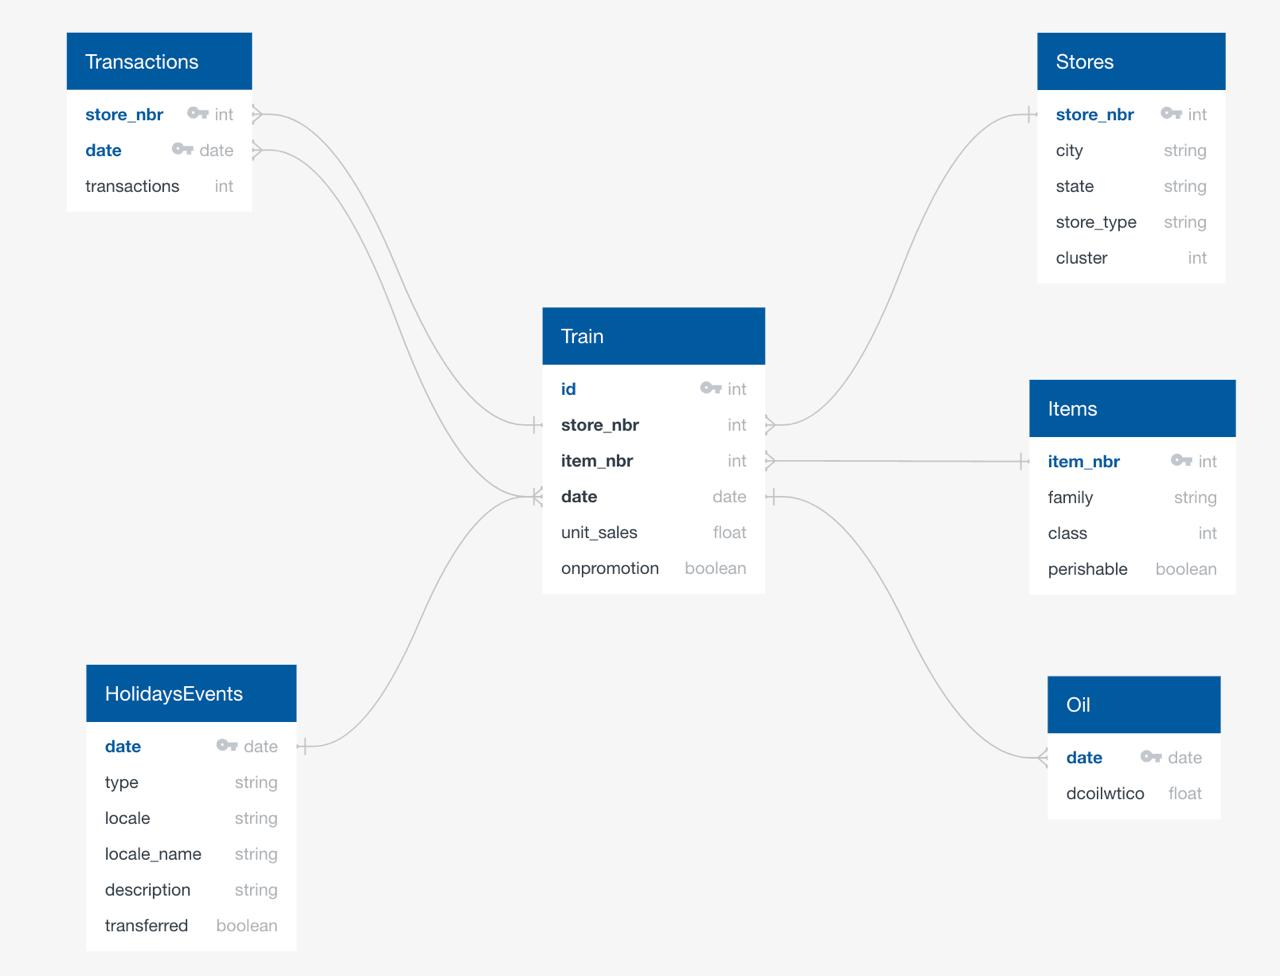

# Data Source

The data was provided by Ecuador’s largest retail competition for a competition and is publicly available on kaggle and is available at:  https://www.kaggle.com/competitions/favorita-grocery-sales-forecasting/data.


Summary of File Descriptions and Data Fields

**train.csv:**

Contains training data with target unit_sales by date, store_nbr, and item_nbr, labeled by id.
unit_sales can be integer (e.g., bag count) or float (e.g., weight).
Negative unit_sales indicates item returns.
onpromotion indicates if an item was on promotion (16% values are NaN).
Rows with zero unit_sales are excluded, and no data indicates if an item was in stock.
Some items in training data do not appear in test data.

**stores.csv:**

Metadata for stores: city, state, type, and cluster (grouping of similar stores).

**items.csv:**

Metadata for items: family, class, and perishable status.
Perishable items have a weight of 1.25; others are weighted at 1.0.\

**transactions.csv:**

Count of sales transactions for each date and store_nbr during the training period.

**oil.csv:**

Daily oil prices for both train and test periods, reflecting Ecuador’s economic dependence on oil.

**holidays_events.csv:**

Metadata on holidays and events.

Key details:

transferred column: Indicates holidays officially moved to a different date.

Bridge: Additional holiday days for long weekends.

Work Day: Non-regular workdays compensating for Bridge.

Additional holidays like Christmas Eve added to the regular calendar.

# Data Cleaning and Transformations

In [ ]:
#Query to join all the different tables in the retail data along with data cleaning - replacing nulls with 0 or false based on column attributes

%%bigquery
CREATE OR REPLACE VIEW `ba-775-team-05.Retail_data.Retail_data_Merged_View` AS (
SELECT *
FROM (
    SELECT
        train.id, train.date, train.store_nbr, train.item_nbr, train.unit_sales,IFNULL(train.onpromotion, 'False') AS onpromotion,
        transactions.transactions,
        IFNULL(oil.dcoilwtico,0) as oil_influence,
        items.family, items.class, items.perishable,
        IFNULL(holidays_events.type, 'No Holiday') AS holiday_event_type, IFNULL(holidays_events.locale,'No Info') as locale, IFNULL(holidays_events.locale_name,'No Info') as locale_name,
        IFNULL(holidays_events.description,'No Description') as description, IFNULL(holidays_events.transferred,false) as transferred,
        stores.city, stores.state, stores.type as store_type, stores.cluster,
        ROW_NUMBER() OVER (PARTITION BY train.id ORDER BY train.date) AS row_num
    FROM
        `ba-775-team-05.Retail_data.train` AS train
    LEFT JOIN
        `ba-775-team-05.Retail_data.transactions` AS transactions
    ON
        train.store_nbr = transactions.store_nbr
    AND train.date = transactions.date
    LEFT JOIN
        `ba-775-team-05.Retail_data.oil` AS oil
    ON
        train.date = oil.date
    LEFT JOIN
        `ba-775-team-05.Retail_data.items` AS items
    ON
        train.item_nbr = items.item_nbr
    LEFT JOIN
        `ba-775-team-05.Retail_data.holidays_events` AS holidays_events
    ON
        train.date = holidays_events.date
    LEFT JOIN
        `ba-775-team-05.Retail_data.Stores` AS stores
    ON
        train.store_nbr = stores.store_nbr
) AS partitioned_data
WHERE row_num = 1
);

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=262006177488-ka1m0ue4fptfmt9siejdd5lom7p39upa.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fpydata-google-auth.readthedocs.io%2Fen%2Flatest%2Foauth.html&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform&state=N33ixXXYdukgXM1kVR6g3vmj7twxGD&prompt=consent&access_type=offline


In [ ]:
#Query to create a Seperate View in which we are creating a new column transactions_new in which we are replacing nulls with the average transactions for a given store for a given month

%%bigquery
CREATE OR REPLACE VIEW `ba-775-team-05.Retail_data.Retail_Data_Transactions_Processed` AS (
SELECT
    id,
    store_nbr,
    date,
    transactions,
    EXTRACT(YEAR FROM date) AS year,
    EXTRACT(MONTH FROM date) AS month,
    COALESCE(
        transactions,
        AVG(transactions) OVER (
            PARTITION BY store_nbr, EXTRACT(YEAR FROM date), EXTRACT(MONTH FROM date)
        )
    ) AS transactions_new
FROM
    `ba-775-team-05.Retail_data.Retail_data_Merged_View`
);


In [ ]:
#Query to create the final Processed table in which are joining the transactions processed table with the Merged data to replace the null transactions with the average transactions for a store for a given month year

%%bigquery
CREATE OR REPLACE VIEW `ba-775-team-05.Retail_data.Retail_Data_Final` AS (
SELECT
    main.id,
    main.date,
    main.store_nbr,
    main.item_nbr,
    main.unit_sales,
    main.onpromotion,
    merged.transactions_new AS transactions_n,
    main.oil_influence,
    main.family,
    main.class,
    main.perishable,
    main.holiday_event_type,
    main.locale,
    main.locale_name,
    main.description,
    main.transferred,
    main.city,
    main.state,
    main.store_type,
    main.cluster
FROM
    `ba-775-team-05.Retail_data.Retail_data_Merged_View` AS main
LEFT JOIN
    `ba-775-team-05.Retail_data.Retail_Data_Transactions_Processed` AS merged
ON
    main.store_nbr = merged.store_nbr
    AND main.date = merged.date
    AND main.id = merged.id);

In [ ]:
## Validation Queries

%%bigquery

SELECT id AS id, COUNT(*) AS count
FROM `ba-775-team-05.Retail_data.Retail_Data_Final`
GROUP BY id;


SELECT date AS date_cm, COUNT(*) AS count
FROM `ba-775-team-05.Retail_data.Retail_Data_Final`
GROUP BY date_cm;


SELECT store_nbr AS store_nbr, COUNT(*) AS count
FROM `ba-775-team-05.Retail_data.Retail_Data_Final`
GROUP BY store_nbr;


SELECT item_nbr AS item_nbr,COUNT(*) AS count
FROM `ba-775-team-05.Retail_data.Retail_Data_Final`
GROUP BY item_nbr;


SELECT unit_sales AS unit_sales, COUNT(*) AS count
FROM `ba-775-team-05.Retail_data.Retail_Data_Final`
GROUP BY unit_sales;


SELECT onpromotion AS onpromotion, COUNT(*) AS count
FROM `ba-775-team-05.Retail_data.Retail_Data_Final`
GROUP BY onpromotion;


SELECT transactions_n AS transactions, COUNT(*) AS count
FROM `ba-775-team-05.Retail_data.Retail_Data_Final`
GROUP BY transactions;


SELECT oil_influence AS dcoilwtico, COUNT(*) AS count
FROM `ba-775-team-05.Retail_data.Retail_Data_Final`
GROUP BY dcoilwtico;


SELECT family AS family, COUNT(*) AS count
FROM `ba-775-team-05.Retail_data.Retail_Data_Final`
GROUP BY family;


SELECT class AS class, COUNT(*) AS count
FROM `ba-775-team-05.Retail_data.Retail_Data_Final`
GROUP BY class;


SELECT perishable AS perishable, COUNT(*) AS count
FROM `ba-775-team-05.Retail_data.Retail_Data_Final`
GROUP BY perishable;


SELECT holiday_event_type AS holiday_event_type,COUNT(*) AS count
FROM `ba-775-team-05.Retail_data.Retail_Data_Final`
GROUP BY holiday_event_type;


SELECT locale AS locale, COUNT(*) AS count
FROM `ba-775-team-05.Retail_data.Retail_Data_Final`
GROUP BY locale;


SELECT locale_name AS locale_name, COUNT(*) AS count
FROM `ba-775-team-05.Retail_data.Retail_Data_Final`
GROUP BY locale_name;


SELECT description AS description,COUNT(*) AS count
FROM `ba-775-team-05.Retail_data.Retail_Data_Final`
GROUP BY description;

SELECT transferred AS transferred,COUNT(*) AS count
FROM `ba-775-team-05.Retail_data.Retail_Data_Final`
GROUP BY transferred;


SELECT city AS city,COUNT(*) AS count
FROM `ba-775-team-05.Retail_data.Retail_Data_Final`
GROUP BY city;


SELECT state AS state,COUNT(*) AS count
FROM `ba-775-team-05.Retail_data.Retail_Data_Final`
GROUP BY state;


SELECT store_type AS store_type, COUNT(*) AS count
FROM `ba-775-team-05.Retail_data.Retail_Data_Final`
GROUP BY store_type;


SELECT cluster AS cluster_cm,COUNT(*) AS count
FROM `ba-775-team-05.Retail_data.Retail_Data_Final`
GROUP BY cluster_cm;


There are 33 different product families. To improve the ease of analysis, we will categorize these families into segments based on priod domain knowledge.

In [ ]:
#Creating a mapping dictionary
%%bigquery
CREATE OR REPLACE TABLE ba-775-team-05.Retail_data.Retail_Data_Final_1 AS
SELECT *,
    CASE
        WHEN family IN ('DELI','GROCERY I', 'GROCERY II', 'BEVERAGES','BREAD/BAKERY', 'DAIRY', 'EGGS', 'PRODUCE', 'MEATS', 'POULTRY', 'SEAFOOD', 'FROZEN FOODS', 'PREPARED FOODS') THEN 'Food and Beverage'
        WHEN family IN ('CLEANING', 'HOME CARE', 'HOME AND KITCHEN I', 'HOME AND KITCHEN II') THEN 'Home Essentials'
        WHEN family IN ('LADIESWEAR', 'LINGERIE') THEN 'Apparel'
        WHEN family IN ('BEAUTY', 'PERSONAL CARE', 'BABY CARE') THEN 'Personal Care'
        WHEN family IN ('LIQUOR,WINE,BEER') THEN 'Alcoholic Beverages'
        WHEN family IN ('PET SUPPLIES') THEN 'Pet Supplies'
        WHEN family IN ('PLAYERS AND ELECTRONICS','HOME APPLIANCES') THEN 'Electronics'
        WHEN family IN ('MAGAZINES', 'BOOKS') THEN 'Media'
        WHEN family IN ('HARDWARE','LAWN AND GARDEN') THEN 'Hardware'
        #WHEN family IN ('CELEBRATION','SCHOOL AND OFFICE SUPPLIES','AUTOMOTIVE') THEN 'Others'
        ELSE 'Other'
    END AS product_segment
FROM ba-775-team-05.Retail_data.Retail_Data_Final;


In [ ]:
## Exploring the final dataset

%%bigquery

Select * from `ba-775-team-05.Retail_data.Retail_Data_Final_1` limit 100;

**Data Merge:**

Several tables of the Retail dataset have been merged: train, transactions, oil, items, holidays_events, stores into one view called the Retail_data_Merged_View. The resulting dataset included all the attributes that were applicable for analysis on sales, promotion, store details, item information, holiday impacts, and oil price influences.

**Handling Missing Values:**

**1.Numerical Columns:** Missing values in the
column of oil.dcoilwtico (as renamed in oil_influence) is replaced with 0 to not cause any computation errors and to maintain the flow of data.

**2.Boolean/Flag Columns:** The missing values in boolean columns like onpromotion, holidays_events.transferred, etc are set to false.

**3.Categorical Columns:** All the text-type columns were filled with default values with meaningful text like "No Holiday" for holiday_event_type and "No Info" where applicable in location-based columns, like locale, locale_name, which offered context in place of an entry.

**Handling Duplicates:**
Duplicates in the final table were handled by partitioning the data based on store id and date, giving a row number with the ROW_NUMBER() window function, then keeping only the latest record by filtering to row number 1 so that only the latest entry related to every id would be retained.

**Treating Missing Transaction data:**
Following this, a view was created, Retail_Data_Transactions_Processed, through which the missing transaction values were imputed. That view replaced the null values in the column transactions_new via the mean calculation of the transactions for each store_nbr-year-month grouping to create a more robust and accurate transactions dataset.

**Final View:**
Retail_Data_Final joined Retail_data_Merged_View with the processed transaction data in order to replace missing transactions with the monthly average for continuity in the transactions recorded. Captured in this integrated dataset are all cleaned and imputed data fields in one place for efficient analysis.

**Checks for Data Quality and Validation:**
Validations were performed to ensure good quality data for all attributes. The count summary, distribution were checked regarding key identifiers like id, store_nbr, item_nbr, numerical columns like unit_sales, transactions_n, and fields relating to categorical like family, class, holiday_event_type, etc. These checks summed up, stating that this data was full and accurate; hence, it was ready to be used for further analysis.

# Exploratory Data Analysis

In [ ]:
%%bigquery
SELECT COUNT(id)
FROM `ba-775-team-05.Retail_data.Retail_Data_Final`;

Query is running:   0%|          |

Downloading:   0%|          |

,f0_
0,125497040


There are total 125 Million unique row id's . Each row shows unit level sales for a particular date, store code and item code combination

In [ ]:
%%bigquery
SELECT COUNT(DISTINCT store_nbr)
FROM `ba-775-team-05.Retail_data.Retail_Data_Final`;




Query is running:   0%|          |

Downloading:   0%|          |

,f0_
0,54


There are total 54 unique store id's implying that the retail organization has 54 stores across ecuador

In [ ]:
%%bigquery
SELECT COUNT(DISTINCT item_nbr)
FROM `ba-775-team-05.Retail_data.Retail_Data_Final`;

Query is running:   0%|          |

Downloading:   0%|          |

,f0_
0,4036


There are 4036 distinct item codes implying that the retail firm sells 4036 different SKU's across Ecuador

In [ ]:
%%bigquery
SELECT DISTINCT family
FROM `ba-775-team-05.Retail_data.Retail_Data_Final`;

Query is running:   0%|          |

Downloading:   0%|          |

,family
0,BREAD/BAKERY
1,EGGS
2,HOME APPLIANCES
3,BEAUTY
4,PERSONAL CARE
5,MEATS
6,FROZEN FOODS
7,HOME AND KITCHEN II
8,BOOKS
9,PRODUCE


Building on the exploratory findings, we now delve into specific insights across key areas to answer our primary questions and reveal actionable patterns.

# Insights

“We begin our insights section by examining product and promotion-related trends, exploring how various segments and promotional efforts impact sales.

## Product and Promotion Insights

Q1 What is the volume of sales share by product segment and families?

In [ ]:
%%bigquery
WITH Overall_Sales AS (
  SELECT SUM(unit_sales) AS Overall_Unit_sales
  FROM ba-775-team-05.Retail_data.Retail_Data_Final_1
)

SELECT
    product_segment,
    FORMAT('%.0f', SUM(unit_sales)) AS total_unit_sales,
    ROUND(SUM(unit_sales) / (SELECT Overall_Unit_sales FROM Overall_Sales),2) * 100 AS percent_share
FROM ba-775-team-05.Retail_data.Retail_Data_Final_1
GROUP BY product_segment
ORDER BY percent_share DESC;


Query is running:   0%|          |

Downloading:   0%|          |

,product_segment,total_unit_sales,percent_share
0,Food and Beverage,919240766,86.0
1,Home Essentials,116922319,11.0
2,Personal Care,24928885,2.0
3,Alcoholic Beverages,7744385,1.0
4,Apparel,1302866,0.0
5,Other,1585256,0.0
6,Electronics,604138,0.0
7,Pet Supplies,356584,0.0
8,Hardware,652279,0.0
9,Media,272791,0.0


The sales share by product segment for Corporación Favorita is overwhelmingly led by Food and Beverage, which makes up 86% of total unit sales, emphasizing its importance in the company’s sales mix. Home Essentials follows with 11%, while Personal Care and Alcoholic Beverages account for 2% and 1%, respectively. The remaining segments—Apparel, Hardware, Pet Supplies, Media, Electronics, and Other—each contribute less than 1%, showing limited impact. Which highlights the dominance of essential goods, particularly food, in Corporación Favorita’s overall sales.

For these Top selling families, lets look at the proportion of units sold ON promotion vs Off promotion

In [ ]:
%%bigquery
WITH Overall_Sales AS (
  SELECT SUM(unit_sales) AS Overall_Unit_sales
  FROM ba-775-team-05.Retail_data.Retail_Data_Final_1),
  family_sales AS(SELECT
    product_segment,family,
    FORMAT('%.0f', SUM(unit_sales)) AS total_unit_sales,
    ROUND((SUM(unit_sales) / (SELECT Overall_Unit_sales FROM Overall_Sales)),2) * 100 AS percent_share,
    RANK() OVER(PARTITION BY product_segment ORDER BY SUM(unit_sales) DESC) AS rank
FROM ba-775-team-05.Retail_data.Retail_Data_Final_1
GROUP BY product_segment,family)
SELECT *
FROM family_sales
WHERE rank <=5 AND product_segment IN ('Food and Beverage','Home Essentials','Personal Care')
ORDER BY product_segment,percent_share DESC;


Query is running:   0%|          |

Downloading:   0%|          |

,product_segment,family,total_unit_sales,percent_share,rank
0,Food and Beverage,GROCERY I,343461728,32.0,1
1,Food and Beverage,BEVERAGES,216942246,20.0,2
2,Food and Beverage,PRODUCE,122704679,11.0,3
3,Food and Beverage,DAIRY,64487256,6.0,4
4,Food and Beverage,BREAD/BAKERY,42133946,4.0,5
5,Home Essentials,CLEANING,97518398,9.0,1
6,Home Essentials,HOME CARE,16022135,1.0,2
7,Home Essentials,HOME AND KITCHEN I,1861229,0.0,3
8,Home Essentials,HOME AND KITCHEN II,1520557,0.0,4
9,Personal Care,PERSONAL CARE,24580943,2.0,1


The Food and Beverage segment dominates sales volume with top families like GROCERY I (32%), BEVERAGES (20%), and PRODUCE (11%), indicating their essential role in Corporación Favorita‘s sales. Other families within this segment, such as DAIRY (6%) and BREAD/BAKERY (4%), contribute smaller shares. The Home Essentials segment is led by CLEANING (9%), with smaller contributions from HOME CARE (1%) and Home and Kitchen sub-categories, each below 1%. Within Personal Care, PERSONAL CARE products account for 2%, while BEAUTY and BABY CARE hold minimal shares.

Q2 What is the impact of promotions (onpromotion) on unit sales and transaction volumes?

In [ ]:
%%bigquery
SELECT
    onpromotion,
    ROUND(SUM(unit_sales) / 1000000, 2) AS total_unit_sales_millions,
    ROUND(SUM(transactions_n) / 1000000, 2) AS total_transaction_volume_millions,
    ROUND(AVG(unit_sales), 2) AS avg_unit_sales
FROM
    ba-775-team-05.Retail_data.Retail_Data_Final
GROUP BY
    onpromotion;

Query is running:   0%|          |

Downloading:   0%|          |

,onpromotion,total_unit_sales_millions,total_transaction_volume_millions,avg_unit_sales
0,False,968.43,221947.43,8.23
1,True,105.18,14097.57,13.47


Promotions significantly increase the average number of units sold per transaction, but the overall transaction volume remains higher for non-promoted items due to their larger sales base.

For these Top selling families, lets look at the proportion of units sold ON promotion vs Off promotion

Q3 What Proportion of Product segments and families have their product on promotion and what percentage of products are perishable?

In [ ]:
%%bigquery


WITH promotion_sales AS (
  SELECT
  product_segment,family, SUM(unit_sales) AS promotion_sales
  FROM ba-775-team-05.Retail_data.Retail_Data_Final_1
  WHERE onpromotion = 'True'
  GROUP BY product_segment,family),
  non_promotion_sales AS (SELECT product_segment,family,SUM(unit_sales) AS non_promotion_sales
  FROM ba-775-team-05.Retail_data.Retail_Data_Final_1
  WHERE onpromotion = 'False'
  GROUP BY product_segment,family),
  perishable_sales AS (
  SELECT
    product_segment, family, SUM(unit_sales) AS perishable_sales
  FROM ba-775-team-05.Retail_data.Retail_Data_Final_1
  WHERE perishable = 1
  GROUP BY product_segment, family)



SELECT
    promo.product_segment,promo.family,
    FORMAT('%.0f',promo.promotion_sales+non_promo.non_promotion_sales) AS total_unit_sales,
    COALESCE(perishable.perishable_sales, 0) /(promo.promotion_sales+non_promo.non_promotion_sales)*100 AS percent_persishable,
    ROUND(promo.promotion_sales/(promo.promotion_sales+non_promo.non_promotion_sales),2)*100 AS percent_promotion
FROM promotion_sales AS promo
LEFT JOIN non_promotion_sales AS non_promo
ON promo.family = non_promo.family AND promo.product_segment = non_promo.product_segment
LEFT JOIN perishable_sales AS perishable
ON promo.family = perishable.family  AND promo.product_segment = perishable.product_segment
WHERE promo.product_segment IN ('Food and Beverage','Home Essentials','Personal Care')
ORDER BY promo.product_segment,percent_promotion DESC;


Query is running:   0%|          |

Downloading:   0%|          |

,product_segment,family,total_unit_sales,percent_persishable,percent_promotion
0,Food and Beverage,PRODUCE,122704679,100.0,20.0
1,Food and Beverage,MEATS,31086468,100.0,16.0
2,Food and Beverage,SEAFOOD,2015396,100.0,16.0
3,Food and Beverage,DELI,24110322,100.0,15.0
4,Food and Beverage,EGGS,15588296,100.0,15.0
5,Food and Beverage,POULTRY,31876004,100.0,14.0
6,Food and Beverage,FROZEN FOODS,14071786,0.0,12.0
7,Food and Beverage,BEVERAGES,216942246,0.0,9.0
8,Food and Beverage,DAIRY,64487256,100.0,8.0
9,Food and Beverage,BREAD/BAKERY,42133946,100.0,8.0


In Corporación Favorita, promotional sales are focused on specific families within Food and Beverage and Home Essentials. In Food and Beverage, PRODUCE leads with 20% of units sold on promotion, followed by SEAFOOD and MEATS at 16%, emphasizing fresh items. Staples like BEVERAGES and GROCERY I have lower promotion rates at 9% and 7%. In Home Essentials, HOME AND KITCHEN II sees the highest promotion rate at 25%, with HOME CARE at 10%. In Personal Care, BEAUTY has 10% on promotion. These figures suggest targeted promotions primarily on fresh foods and select household items.

Now we will look at promotion ratios of all product segments and their perishable ratios as well

In [ ]:
%%bigquery


WITH promotion_sales AS (
  SELECT
  product_segment, SUM(unit_sales) AS promotion_sales
  FROM ba-775-team-05.Retail_data.Retail_Data_Final_1
  WHERE onpromotion = 'True'
  GROUP BY product_segment),
  non_promotion_sales AS (SELECT product_segment,SUM(unit_sales) AS non_promotion_sales
  FROM ba-775-team-05.Retail_data.Retail_Data_Final_1
  WHERE onpromotion = 'False'
  GROUP BY product_segment),
  perishable_sales AS (
  SELECT
    product_segment, SUM(unit_sales) AS perishable_sales
  FROM ba-775-team-05.Retail_data.Retail_Data_Final_1
  WHERE perishable = 1
  GROUP BY product_segment)



SELECT
    promo.product_segment,
    FORMAT('%.0f',promo.promotion_sales+non_promo.non_promotion_sales) AS total_unit_sales,
    COALESCE(perishable.perishable_sales, 0) /(promo.promotion_sales+non_promo.non_promotion_sales)*100 AS percent_persishable,
    promo.promotion_sales/(promo.promotion_sales+non_promo.non_promotion_sales)*100 AS percent_promotion
FROM promotion_sales AS promo
LEFT JOIN non_promotion_sales AS non_promo
ON promo.product_segment = non_promo.product_segment
LEFT JOIN perishable_sales AS perishable
ON promo.product_segment = perishable.product_segment
ORDER BY percent_promotion DESC;


Query is running:   0%|          |

Downloading:   0%|          |

,product_segment,total_unit_sales,percent_persishable,percent_promotion
0,Other,1585256,0.000000,10.515526
1,Food and Beverage,919240766,37.291888,10.244267
2,Hardware,652279,0.000000,8.510775
3,Personal Care,24928885,0.000000,7.514897
4,Home Essentials,116922319,0.000000,7.240555
5,Alcoholic Beverages,7744385,0.000000,5.467923
6,Pet Supplies,356584,0.000000,2.523108
7,Apparel,1302866,0.000000,1.089905
8,Electronics,604138,0.000000,0.825474
9,Media,272791,0.000000,0.185123


The table shows that Food and Beverage has the highest combination of promotion ratio (10.24%) and perishable ratio (37.29%), indicating a focus on promoting perishable goods. Other products also have a high promotion ratio (10.52%) but no perishable items, suggesting general promotional efforts. Hardware and Personal Care have moderate promotion ratios around 8% without perishables, while segments like Pet Supplies and Media have low promotion ratios (2.52% and 0.18%). Overall, Food and Beverage leads in both perishability and promotional focus, with other segments promoting durable goods.

Q4 What are the families having greatest volatility with promotions?

In [ ]:
%%bigquery
WITH MonthlySales AS (
    SELECT family,EXTRACT(MONTH FROM date) AS month,onpromotion, SUM(unit_sales) AS monthly_sales
    FROM ba-775-team-05.Retail_data.Retail_Data_Final_1
    GROUP BY family, month, onpromotion
),
SalesVolatility AS (
    SELECT family,AVG(monthly_sales) AS avg_sales,STDDEV(monthly_sales) AS sales_volatility,COUNTIF(onpromotion = 'True') AS promotion_months
    FROM MonthlySales
    GROUP BY family
)
SELECT family, FORMAT('%.0f',avg_sales) AS AVG_sales, FORMAT('%.0f',sales_volatility) AS Sales_volatility,promotion_months
FROM SalesVolatility
WHERE promotion_months >= 3
    AND sales_volatility > (SELECT AVG(sales_volatility) FROM SalesVolatility)
ORDER BY sales_volatility DESC

Query is running:   0%|          |

Downloading:   0%|          |

,family,AVG_sales,Sales_volatility,promotion_months
0,BEVERAGES,9039260,7694247,12
1,CLEANING,4063267,3662380,12
2,PRODUCE,5112695,3372923,12
3,DAIRY,2686969,2328800,12
4,BREAD/BAKERY,1755581,1529463,12
5,GROCERY I,14310905,12709998,12


GROCERY I and BEVERAGES exhibit the highest average sales and volatility, indicating that their sales fluctuate widely month-to-month. This volatility may be driven by promotions, seasonal factors, or other demand shifts. Other categories like CLEANING and PRODUCE also show substantial volatility, though lower than the top categories.

Given the high volatility, especially in GROCERY I and BEVERAGES, careful inventory planning is essential to avoid stockouts or overstocks. During promotional periods, extra inventory might be necessary to meet demand, while in non-promotional months, stock levels could be adjusted to reduce excess. Categories like DAIRY and PRODUCE might respond well to seasonal or targeted holiday promotions, while GROCERY I and BEVERAGES could see benefits from consistent year-round offers. High average sales in GROCERY I and BEVERAGES suggest they are core revenue drivers. Enhancing promotions and optimizing stock for these categories during high-demand periods could boost sales further. For lower average sales categories, more frequent but smaller promotions might stabilize demand.

### **Key Observations**

1.	**Strategic Focus on High-Demand Categories**: The Food and Beverage segment dominates sales (86%), highlighting the need to prioritize inventory and promotions for Grocery and Beverages, which drive the majority of revenue.

2.	**Promotions Drive Sales but Require Precision:** Promotions significantly boost sales for fresh items and household goods, but categories like Beverages and Cleaning exhibit high volatility, requiring careful timing and targeting to maximize returns.

3.	**Seasonal and Macroeconomic Impacts:** Sales peak during holidays like December and surge during events (e.g., 2016 earthquake), while external factors like oil price fluctuations influence consumer purchasing behavior, emphasizing the need for agile planning.

Having explored product-level insights, we now shift our focus to store-level trends to understand  differences in customer preferences across store types

## Store Level Insights

The different store types in the supermarket sales dataset typically represent classifications based on location, size, target customer base, and the variety of products offered. While the dataset does not explicitly define each store type (A, B, C, D, E), we can infer their meanings based on general retail classifications and the observed sales patterns

Clusters are a group of nearby stores, here we examine the top selling families for each cluster .

Q1 What are the most popular families in each store clusters?

In [ ]:
%%bigquery
WITH ClusterSales AS (
    SELECT cluster, family, FORMAT('%.0f', SUM(unit_sales)) AS total_sales, RANK() OVER(PARTITION BY cluster ORDER BY SUM(unit_sales) DESC) AS rank
    FROM ba-775-team-05.Retail_data.Retail_Data_Final_1
    GROUP BY cluster, family
)
SELECT cluster, family, total_sales
FROM ClusterSales
WHERE rank <= 2
ORDER BY cluster, total_sales DESC;

Query is running:   0%|          |

Downloading:   0%|          |

,cluster,family,total_sales
0,1,GROCERY I,14539464
1,1,BEVERAGES,11765234
2,2,GROCERY I,8469258
3,2,BEVERAGES,5389235
4,3,GROCERY I,29211212
5,3,BEVERAGES,14620727
6,4,BEVERAGES,8161926
7,4,GROCERY I,16489700
8,5,GROCERY I,16386055
9,5,BEVERAGES,13417859


GROCERY I consistently ranks as the top family across clusters, showing strong demand across different regions. This suggests it’s a staple category that appeals widely, possibly due to essential or high-turnover products. BEVERAGES also ranks highly across multiple clusters, indicating it’s another popular category, potentially driven by its consumable nature and frequent re-purchase rates.

Although all the clusters have substantial demand for both GROCERY I and BEVERAGES. The demand scale for each cluster varies, possibly indicating a slight regional variation in demand or product preference.

Given GROCERY I's high demand across all clusters, maintaining sufficient inventory for this category is essential. Additional stock or priority reordering might be necessary to avoid potential stockouts. For BEVERAGES, inventory focus could be adjusted based on cluster demand, with more stock allocated to clusters with higher sales to optimize resource allocation.

Q2 What is the average transaction volume of different store types?

In [ ]:
%%bigquery
SELECT store_type, AVG(transactions_n) AS avg_transactions
FROM `Retail_data.Retail_Data_Final`
GROUP BY store_type
ORDER BY avg_transactions DESC;

Query is running:   0%|          |

Downloading:   0%|          |

,store_type,avg_transactions
0,A,3264.807914
1,B,1752.077623
2,D,1706.575127
3,E,1204.794211
4,C,1062.253906


Store type A has the highest average transactions, suggesting it has the most customer traffic. Store types B and D also have substantial average transaction counts, though significantly lower than type A. These stores might benefit from analyzing what makes type A more successful to adopt similar practices where possible. Store types E and C have the lowest average transactions, with type C having notably fewer transactions than other types. These stores might require targeted strategies, such as promotional campaigns or store layout adjustments, to increase customer engagement. Resources could be optimized by allocating higher inventory or staff support to store types with higher transaction volumes. Lower-transaction stores may also benefit from efficiency improvements and localized promotions to better capture customer interest.

Q3 How does the presence of promotions affect sales across different stores type?

In [ ]:
%%bigquery
WITH Promotion_Sales AS (
    SELECT
        date,
        unit_sales,
        transactions_n,
        store_type,
        onpromotion,
        CASE WHEN onpromotion = 'True' THEN 'Promotion'
             ELSE 'No Promotion' END AS promotion_status
    FROM ba-775-team-05.Retail_data.Retail_Data_Final
)

SELECT
    promotion_status,
    store_type,
    AVG(unit_sales) AS avg_unit_sales,
    SUM(unit_sales) AS total_unit_sales,
    AVG(transactions_n) AS avg_transactions,
    SUM(transactions_n) AS total_transactions
FROM Promotion_Sales
GROUP BY promotion_status, store_type
ORDER BY promotion_status ASC, store_type ASC;

Query is running:   0%|          |

Downloading:   0%|          |

,promotion_status,store_type,avg_unit_sales,total_unit_sales,avg_transactions,total_transactions
0,No Promotion,A,12.643650,3.202091e+08,3264.886920,8.268548e+10
1,No Promotion,B,7.791969,1.294675e+08,1757.323983,2.919883e+10
2,No Promotion,C,6.121897,1.479453e+08,1065.155730,2.574117e+10
3,No Promotion,D,7.210848,3.180108e+08,1707.949724,7.532352e+10
4,No Promotion,E,7.060994,5.279457e+07,1203.492218,8.998429e+09
5,Promotion,A,21.814490,3.283476e+07,3263.478591,4.912126e+09
6,Promotion,B,12.506206,1.578074e+07,1682.994844,2.123658e+09
7,Promotion,C,9.464245,1.648915e+07,1022.003150,1.780592e+09
8,Promotion,D,12.243259,3.305254e+07,1684.119611,4.546537e+09
9,Promotion,E,11.676691,7.025853e+06,1220.973244,7.346584e+08


Promotions significantly boost average unit sales across all store types at Corporación Favorita. In high-traffic Store Type A, average unit sales increase from 12.64 to 21.81 with promotions. Mid-traffic stores like Types B and D also see gains, with averages rising from 7.79 to 12.51 and 7.21 to 12.24, respectively. Lower-traffic stores, Types C and E, benefit as well, with sales increasing from 6.12 to 9.46 and 7.06 to 11.68. This indicates promotions effectively drive higher sales across all store types.

### **Key Observations**


Customer preferences vary significantly by region and store type. Store Type A records the highest transaction volume,and is also the most affected by promotions as avg sales rise by 9 units for promotion items.

Next, we turn our attention to seasonal trends, investigating how sales fluctuate around holidays and significant events, which offers insights into optimal timing for promotions and inventory adjustments.

## Seasonal Trends

Q1 How do unit sales change around holiday events compared to regular days?

In [ ]:
%%bigquery
WITH Holiday_Sales AS (
    SELECT
        date,
        unit_sales,
        holiday_event_type,
        CASE WHEN holiday_event_type <> 'No Holiday' THEN 'Holiday'
             ELSE 'Non-Holiday' END AS day_type
    FROM ba-775-team-05.Retail_data.Retail_Data_Final
)

SELECT
    day_type,
    ROUND(AVG(unit_sales),2) AS avg_unit_sales,
    FORMAT('%.0f', SUM(unit_sales)) AS total_unit_sales
FROM Holiday_Sales
GROUP BY day_type
ORDER BY day_type ASC;

Query is running:   0%|          |

Downloading:   0%|          |

,day_type,avg_unit_sales,total_unit_sales
0,Holiday,9.04,174977682
1,Non-Holiday,8.47,898632586


Seasonal sales patterns can be understood by looking at average and total sales during the holiday season. From the results, it can be seen that sales increase significantly during the holiday season and that consumer demand will be higher on special occasions, thus providing a basis for future sales forecasts. Understanding sales variances is critical to inventory management, and by forecasting expected holiday sales stores can stock popular items in advance, minimizing the risk of out-of-stocks.

Q2 Are there seasonal trends in sales, and which months have the highest and lowest average sales?

In [ ]:
%%bigquery
SELECT
    EXTRACT(MONTH FROM date) AS month,
    ROUND(AVG(transactions_n),2) AS avg_transactions,
    ROUND(AVG(unit_sales),2) AS avg_sales
FROM `Retail_data.Retail_Data_Final`
GROUP BY month
ORDER BY avg_transactions DESC, avg_sales DESC;

Query is running:   0%|          |

Downloading:   0%|          |

,month,avg_transactions,avg_sales
0,12,2287.12,9.88
1,4,1879.89,8.48
2,5,1878.76,8.37
3,2,1850.00,8.13
4,1,1849.77,8.69
5,3,1848.79,8.50
6,11,1840.76,8.61
7,8,1838.07,8.15
8,6,1836.92,8.39
9,9,1836.65,8.69


The table reveals distinct seasonal sales patterns. December stands out with the highest figures—average sales hitting 9.88 and transactions soaring to 2287.12—likely fueled by the holiday shopping rush. In stark contrast, October sees the lowest activity, with average sales dropping to 8.46 and transactions down to 1812.76, marking a lull in consumer spending.

Q3 How were the total sales on different product segment being affected in the two weeks before and after the earthquake happened on April 16, 2016?

In [ ]:
%%bigquery
WITH sales AS (
    SELECT
        'Before Earthquake' AS period,
        product_segment,
        ROUND(SUM(unit_sales),2) AS total_sales
    FROM `Retail_data.Retail_Data_Final_1`
    WHERE date BETWEEN DATE_SUB('2016-04-16', INTERVAL 2 WEEK) AND DATE_SUB('2016-04-16', INTERVAL 1 DAY)
    GROUP BY product_segment

    UNION ALL

    SELECT
        'After Earthquake' AS period,
        product_segment,
        ROUND(SUM(unit_sales),2) AS total_sales
    FROM `Retail_data.Retail_Data_Final_1`
    WHERE date BETWEEN '2016-04-16' AND DATE_ADD('2016-04-16', INTERVAL 2 WEEK)
    GROUP BY product_segment
)

SELECT
    a.product_segment,
    a.total_sales AS before_earthquake_sales,
    b.total_sales AS after_earthquake_sales,
    CONCAT(ROUND((b.total_sales - a.total_sales) / NULLIF(a.total_sales, 0) * 100, 2), '%') AS sales_growth_rate
FROM sales AS a
JOIN sales AS b
ON  a.product_segment = b.product_segment
    AND a.period = 'Before Earthquake'
    AND b.period = 'After Earthquake'
ORDER BY product_segment, before_earthquake_sales DESC;

Query is running:   0%|          |

Downloading:   0%|          |

,product_segment,before_earthquake_sales,after_earthquake_sales,sales_growth_rate
0,Alcoholic Beverages,58800.00,63683.00,8.3%
1,Apparel,12793.00,13523.00,5.71%
2,Electronics,7066.00,11386.00,61.14%
3,Food and Beverage,9601984.04,12119273.74,26.22%
4,Hardware,4555.00,5159.00,13.26%
5,Home Essentials,1141527.00,1377766.00,20.69%
6,Media,4068.00,6868.00,68.83%
7,Other,19055.00,22829.00,19.81%
8,Personal Care,246847.00,359819.00,45.77%
9,Pet Supplies,5344.00,5265.00,-1.48%


In the two weeks before and after the earthquake on April 16, 2016, in Ecuador, sales across different product segments experienced notable changes. Overall, total sales rose from 11,306,900.06 before the earthquake to 13,585,842.28 after, marking a growth of 20.16%. Among product categories, Food and Beverage increased by 26.22%, and Personal Care surged by 45.77%, indicating heightened demand for essential items and hygiene products post-disaster. Electronics and Media saw remarkable growth rates of 61.14% and 68.83%, respectively, suggesting increased demand for information, entertainment, or replacement items. Categories like Alcoholic Beverages and Home Essentials also experienced moderate growth, reflecting the need for everyday items during recovery. In contrast, Pet Supplies saw a slight decrease of 1.48%, possibly indicating a lower priority for non-essential pet items post-earthquake. Overall, the earthquake led to an increase in sales across most categories, particularly for essential and entertainment-related goods.

### **Key Observations**

Sales peak in December and decline in October, highlighting the importance of seasonality in purchasing behavior. Additionally, the 2016 earthquake triggered increased sales of essential goods, demonstrating the need to align inventory with demand during exceptional events.

After identifying seasonal influences, we now consider the impact of external economic factors, specifically crude oil prices, to understand how broader market conditions may affect transaction volumes

## Oil price Influence

Q1 How do changes in crude oil prices affect transaction volumes across stores? (by year)

In [ ]:
%%bigquery
SELECT
    EXTRACT(YEAR FROM date) AS year,
    ROUND(SUM(transactions_n) / 1000000, 2) AS total_transaction_volume_millions,
    ROUND(AVG(oil_influence), 2) AS avg_oil_price
FROM
    ba-775-team-05.Retail_data.Retail_Data_Final
GROUP BY
    year
ORDER BY
    year;

Query is running:   0%|          |

Downloading:   0%|          |

,year,total_transaction_volume_millions,avg_oil_price
0,2013,31135.29,66.76
1,2014,43549.49,62.54
2,2015,52821.21,32.73
3,2016,64583.12,29.31
4,2017,43955.90,33.00


From 2013 to 2017, transaction volumes generally rose, peaking in 2016 before declining in 2017. The average oil price showed a decreasing trend from 2013 to 2016, potentially indicating a correlation with rising transaction volumes, but saw a modest recovery in 2017. This suggests a possible inverse relationship where lower oil prices could be associated with higher transaction volumes

Now, we move on to an analysis that uses both year and month to gain a more granular view of transaction volumes and average oil prices

Q2 How do changes in crude oil prices affect transaction volumes across stores? (By year and month)

In [ ]:
%%bigquery
SELECT
    EXTRACT(YEAR FROM date) AS year,
    EXTRACT(MONTH FROM date) AS month,
    ROUND(SUM(transactions_n) / 1000000, 2) AS total_transaction_volume_millions,
    ROUND(AVG(oil_influence), 2) AS avg_oil_price
FROM
    ba-775-team-05.Retail_data.Retail_Data_Final
GROUP BY
    year, month
ORDER BY
    year, month;

Query is running:   0%|          |

Downloading:   0%|          |

,year,month,total_transaction_volume_millions,avg_oil_price
0,2013,1,2224.61,65.00
1,2013,2,2151.25,63.61
2,2013,3,2507.50,58.51
3,2013,4,2401.01,66.34
4,2013,5,2553.35,65.96
5,2013,6,2539.79,62.08
6,2013,7,2550.61,73.16
7,2013,8,2644.72,74.34
8,2013,9,2575.60,68.99
9,2013,10,2611.81,73.30


The analysis of oil price influence revealed a significant macroeconomic link between crude oil price fluctuations and transaction volumes across stores, reflecting Ecuador's dependence on oil and its impact on consumer spending power. Temporal analysis by year and month highlighted periods where rising or falling oil prices correlated with changes in purchasing behavior. These findings underscore the importance of external economic factors in driving transaction volumes and provide valuable context for sales patterns. Monitoring oil price trends can help supermarkets anticipate shifts in consumer behavior and adjust strategies to mitigate the effects of economic volatility.

# Dashboard


## Sales Trend Analysis

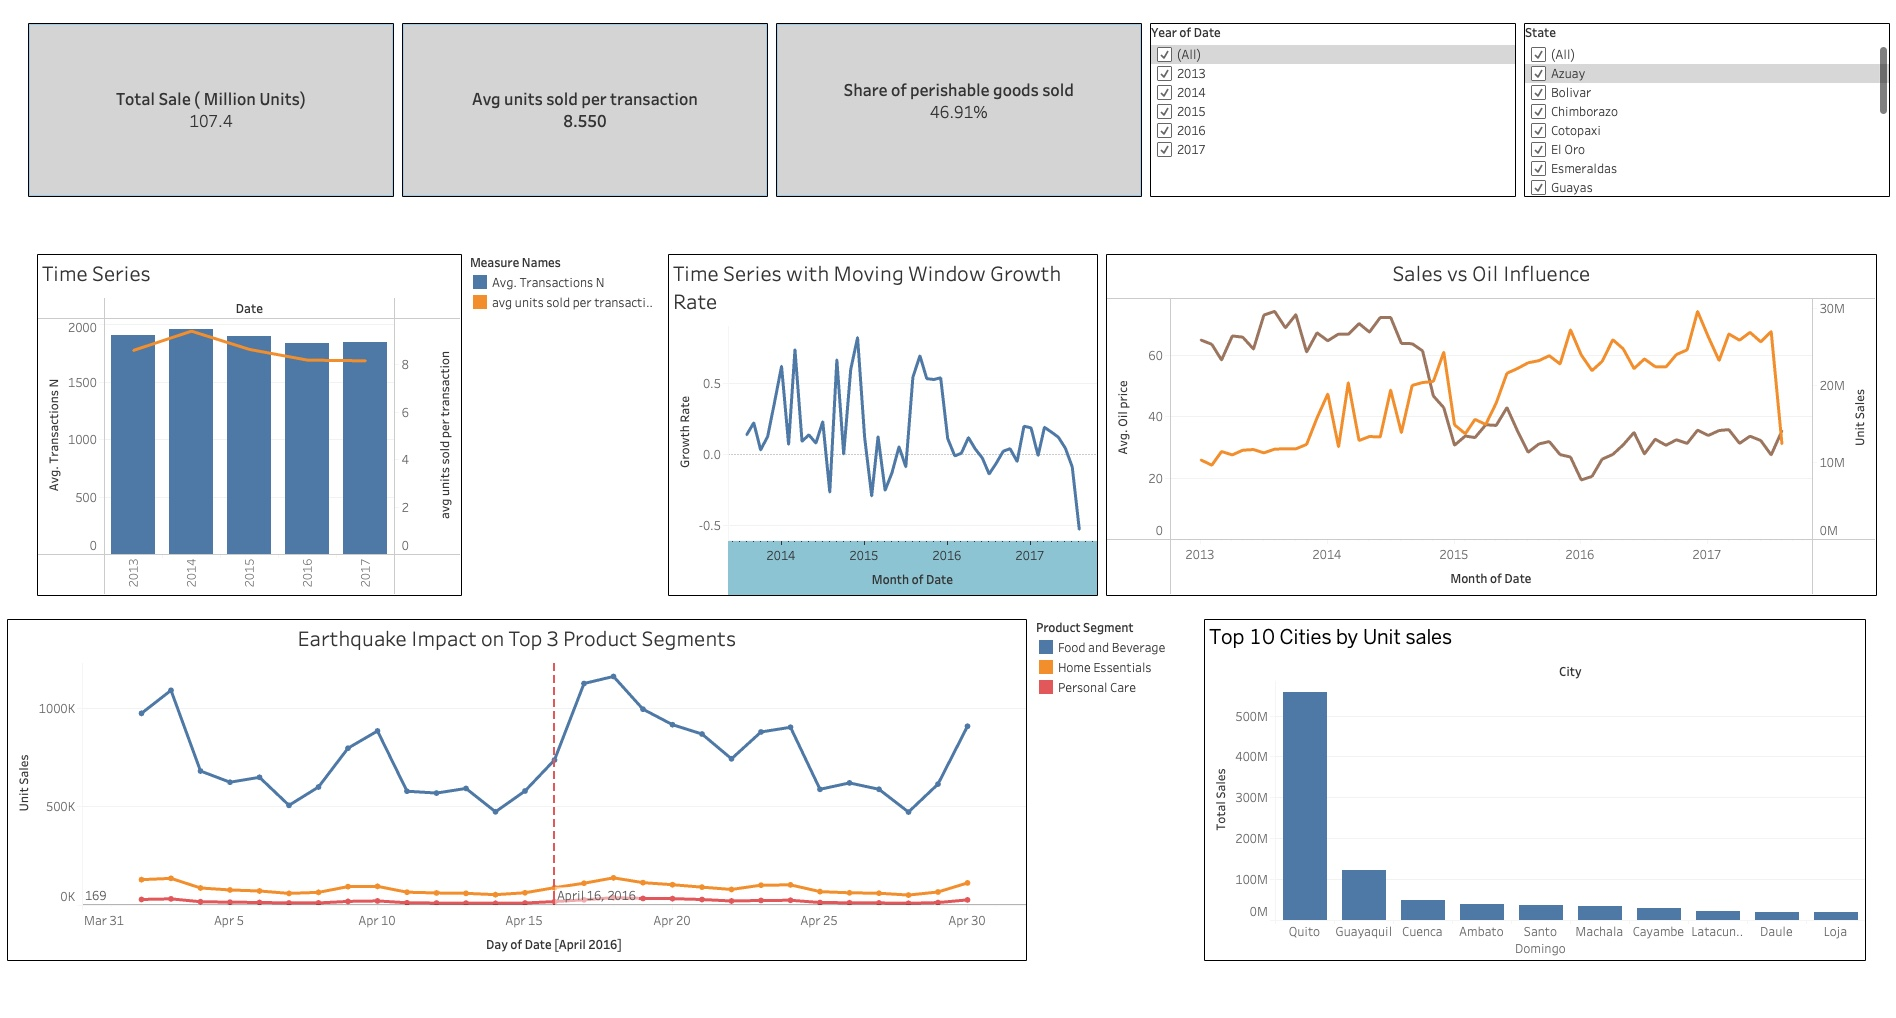

## Product and Promotion Impact Analysis

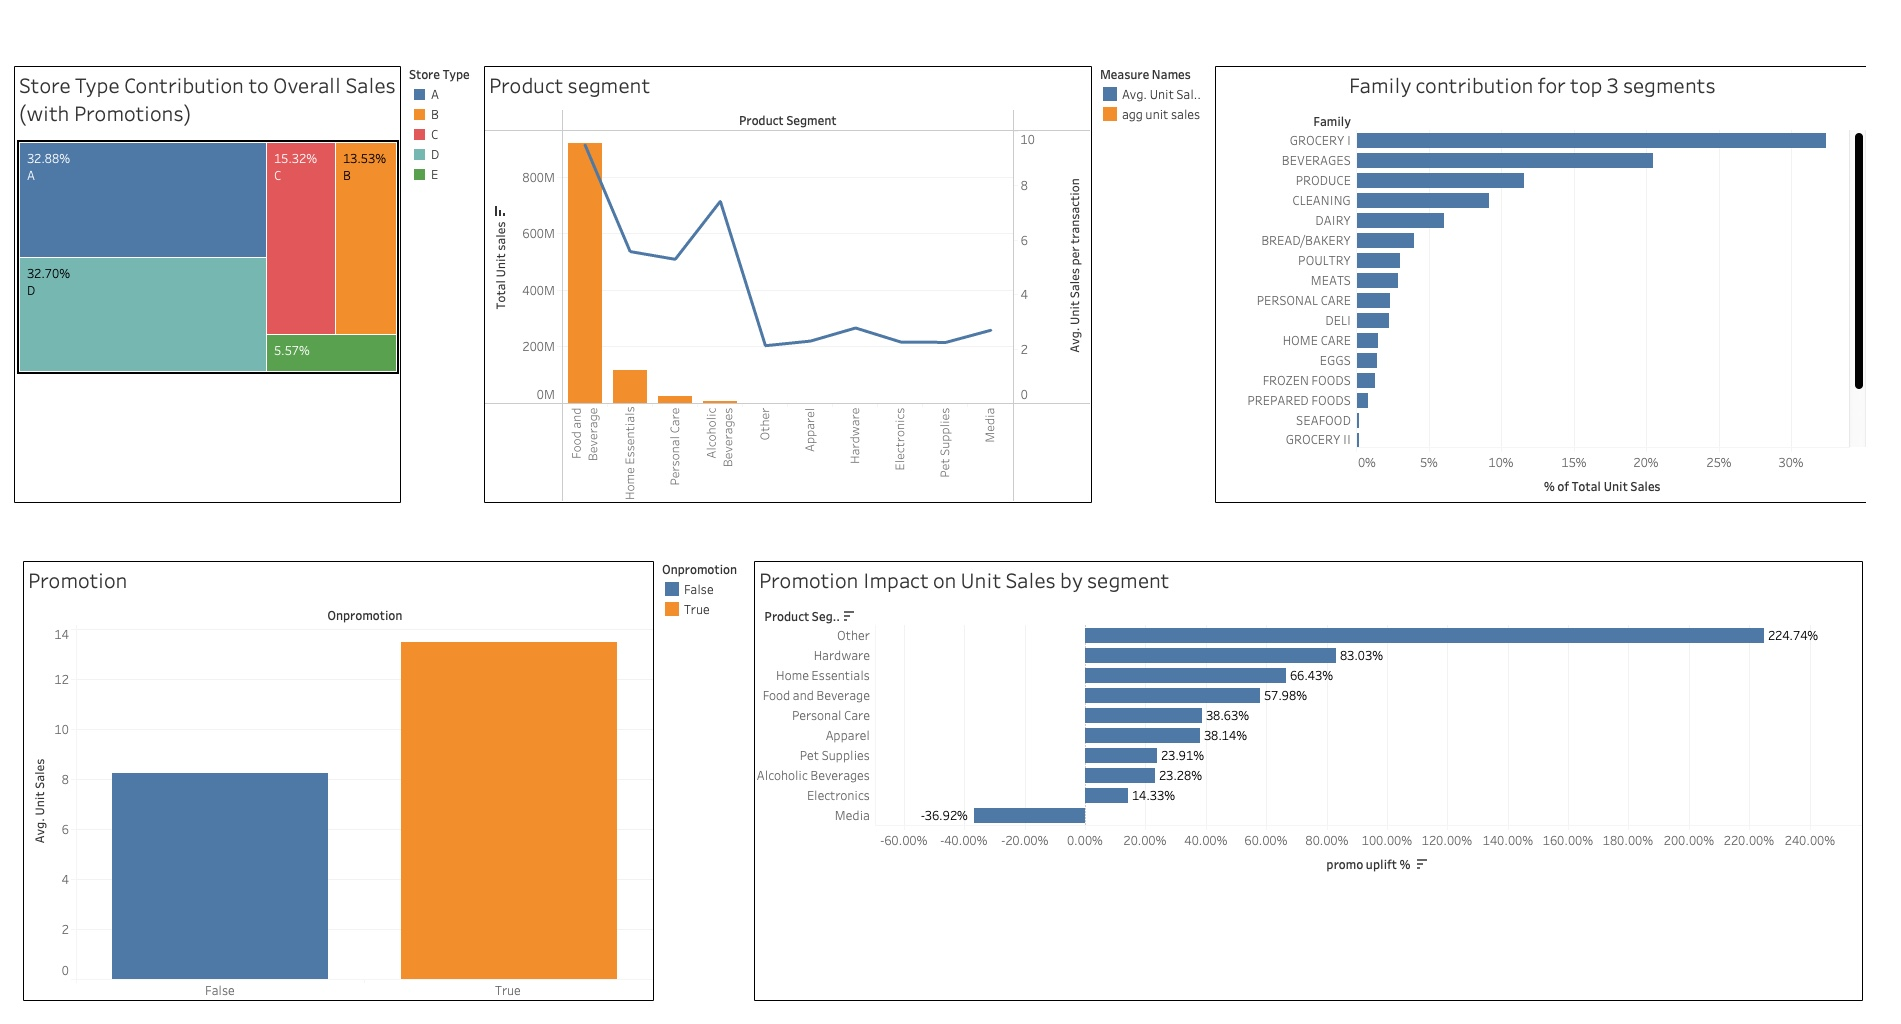

# Challenges

**Data Cleaning:**

Data cleaning involved handling missing values, duplicates, and inconsistencies across multiple fields. Numerical columns like oil influence were imputed with 0, Boolean fields such as onpromotion and transferred were set to False, and categorical fields like holiday_event_type and locale were assigned placeholders such as "No Holiday" or "No Info". Duplicates were resolved using the ROW_NUMBER() function to retain the latest records, while missing transaction data was filled with monthly averages per store. Product categories were grouped into broader segments like Food and Beverage or Home Essentials, and extensive validation checks ensured consistency across key attributes. These efforts prepared a robust and complete dataset for further analysis.


**Data Merging:**

Merging multiple datasets (train, transactions, oil, items, holiday events, and stores) into a single integrated view posed significant challenges. Each dataset contained unique attributes, and aligning these while ensuring consistency required careful data transformation. To address this, we created the Retail_data_Merged_View, which combined these datasets and included relevant attributes such as sales, promotions, store details, holiday impacts, and oil price influences. This process helped us create a consolidated and meaningful dataset for further analysis.




In closing, we summarize our key findings and consider their implications for decision-making, synthesizing the insights from each analysis area into actionable recommendation

# Conclusion


This analysis of supermarket sales patterns in Ecuador highlights key insights into sales dynamics and actionable opportunities for improvement. Store types ‘A’ and ‘D’ contribute the most to overall sales, making them high-priority targets for focused promotional efforts and resource allocation. Promotions have proven effective in driving sales uplift for specific product segments, such as food & beverages and hardware, while underperforming categories like media require strategic reassessment. Regional differences in customer preferences underscore the need for localized product assortments and tailored marketing strategies.

Distinct sales peaks around holidays and events, as well as the influence of macroeconomic factors like oil prices, demonstrate the importance of aligning inventory and promotional timing with these trends. Additionally, external disruptions such as natural disasters impact specific product segments, requiring agile and responsive planning.

**Recommendations:**

•	Focus promotional efforts on high-performing product families and peak periods with high demand.

•	Customize product offerings and pricing strategies to align with regional customer preferences.

•	Align inventory levels with seasonal demand and special events to minimize stockouts or overstocking.

•	Integrate macroeconomic indicators like oil prices into planning to anticipate changes in consumer behavior.

**Future Steps:**

•	Expand the analysis to include customer demographic and behavioral data for deeper insights into purchasing patterns.

•	Leverage advanced predictive analytics to anticipate sales trends and improve planning reliability.

•	Establish real-time monitoring systems to create a feedback loop, allowing for continuous strategy refinement.

•	Collaborate with suppliers to streamline operations and ensure the availability of high-demand products.



# References

https://github.com/soltaniehha/Business-Analytics-Toolbox

https://app.datacamp.com/learn/assignments/ba775-fall-2024-business-analytics-toolbox

https://www.w3schools.com/sql/sql_ref_keywords.asp

https://www.w3schools.com/sql/sql_dates.asp

https://www.kaggle.com/competitions/favorita-grocery-sales-forecasting/overview/evaluation

https://www.cloudskillsboost.google/focuses/3692?parent=catalog

https://www.tableau.com/learn/training

https://public.tableau.com/app/learn/how-to-videos

https://help.tableau.com/current/pro/desktop/en-us/dataview_examples.htm

# Generative AI Disclosure


In completing this project, we utilized Generative AI tools to assist with several aspects of our work. Below is a detailed account of how these tools were used:

* **Coding Debugging:** We used ChatGPT to help debug and resolve issues in our code, as well as to optimize algorithms, improving the overall performance and stability of the code.

* **Brainstorming:** ChatGPT assisted in brainstorming ideas during the early stages of the project, helping us develop and refine our approach.

* **Data Visualization Guidance:** ChatGPT provided instructions on how to calculate specific data metrics add and customize reference lines in Tableau, helping us effectively analyze and visualize our data.

* **Grammar Checks:** Grammarly was used to review the text for grammatical accuracy, ensuring that the language was clear, accurate, and easy to read.

Our team carefully reviewed, edited, and validated all AI-generated content to ensure its accuracy, relevance, and adherence to academic integrity standards.